
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW runup estimation of historical nearshore waves

inputs required: 
  * Nearshore reconstructed historical storms
  * Historical water levels (daily high tides)

in this notebook:
  * HyCReWW runup estimation of historical data


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import datetime
import utide 

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}

var_lims, rbf_coeffs = db.Load_HYCREWW()


In [3]:
# --------------------------------------
# Load nearshore waves for 3 points at sections North, East & South

WVS_E = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_E.pkl')
WVS_S = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_S.pkl')

WVS_E = WVS_E.set_index('Time').to_xarray()
WVS_S = WVS_S.set_index('Time').to_xarray()
print(WVS_E)    
print()
    
    
# --------------------------------------    
# Load astronomical tide from TG

_, TIDE = db.Load_TIDE_hist()  # astronomical tide historical data
TIDE = TIDE.drop_vars('ntr')
TIDE = TIDE.drop_vars('sigma')
TIDE = TIDE.drop_vars('observed')
print(TIDE)

<xarray.Dataset>
Dimensions:  (Time: 111040)
Coordinates:
  * Time     (Time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    Hs       (Time) float64 2.93 3.128 3.092 3.072 ... 1.736 1.765 1.749 1.812
    Tp       (Time) float64 9.963 9.822 9.784 9.669 ... 8.451 8.553 8.559 8.471
    Dir      (Time) float64 73.08 75.26 76.35 76.83 ... 72.58 73.51 72.52 73.06

<xarray.Dataset>
Dimensions:    (time: 184104)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 ... 2016-12-31T23:00:00.000002944
Data variables:
    predicted  (time) float64 ...


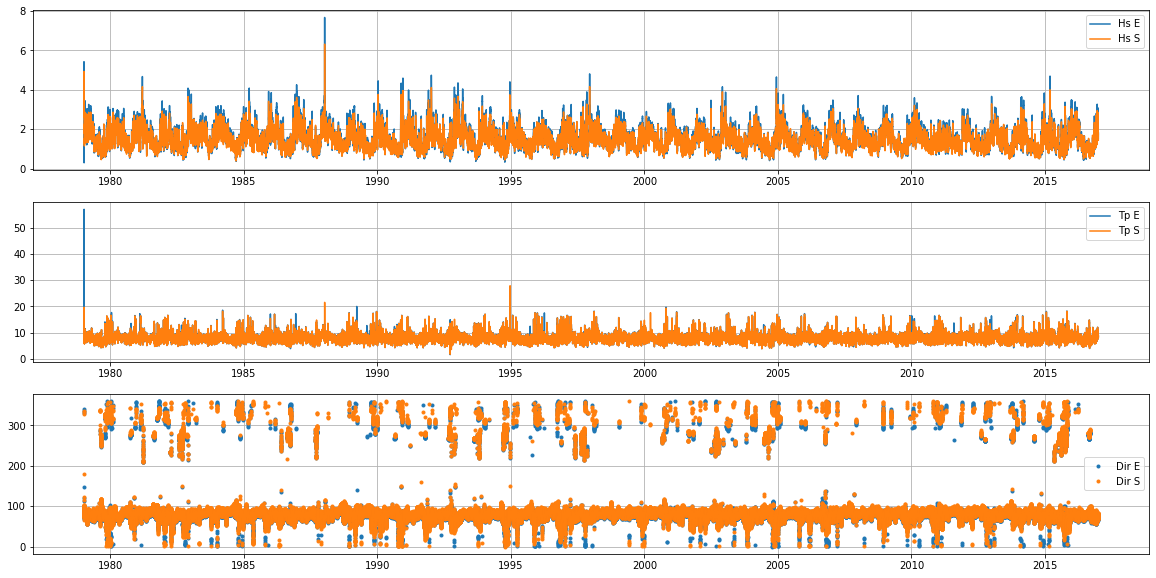

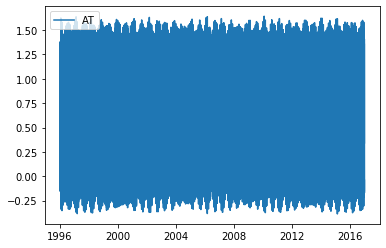

In [4]:
# --------------------------------------
# Plot input data

fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(WVS_E.Time, WVS_E.Hs, label='Hs E')
axs[0].plot(WVS_S.Time, WVS_S.Hs, label='Hs S')
axs[0].legend()
axs[0].grid()

axs[1].plot(WVS_E.Time, WVS_E.Tp, label='Tp E')
axs[1].plot(WVS_S.Time, WVS_S.Tp, label='Tp S')
axs[1].legend()
axs[1].grid()

axs[2].plot(WVS_E.Time, WVS_E.Dir, '.', label='Dir E')
axs[2].plot(WVS_S.Time, WVS_S.Dir, '.', label='Dir S')
axs[2].legend()
axs[2].grid()
#plt.savefig('waves_nearshore.png')

plt.figure()
plt.plot(TIDE.time, TIDE.predicted, label='AT')
plt.legend()

## Obtain base level for Hycreww (daily high tide)

In [5]:
# --------------------------------------
# 99% of AT level

AT = TIDE.predicted - np.nanmean(TIDE.predicted)

level = np.percentile(AT.values, 99)
print(level)


0.8700082670664409



## Hycreww RBF Interpolation: Historical

In [6]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]

    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] > var_lims[vn][0]) &(dset[vn] < var_lims[vn][1])]
    
    
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out


In [7]:
# Input data for hycreww

WVS_E = WVS_E.rename({'Time': 'time'})
WVS_S = WVS_S.rename({'Time': 'time'})

WVS_E = WVS_E.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
WVS_S = WVS_S.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars

WVS_E['hs_lo2'] = WVS_E['hs']/(1.5613*WVS_E['tp']**2)             # calc. hs_lo2
WVS_S['hs_lo2'] = WVS_S['hs']/(1.5613*WVS_S['tp']**2)             # calc. hs_lo2

WVS_E['level'] = level                                            # add level
WVS_S['level'] = level                                            # add level


In [8]:
# Calculate runup with hycreww
dset_E = WVS_E[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_E = hycreww_runup(var_lims, rbf_coeffs, dset_E)

dset_S = WVS_S[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_S = hycreww_runup(var_lims, rbf_coeffs, dset_S)

print(out_hist_E)
print()
print(out_hist_S)

                           hs        tp        dir     level    hs_lo2  \
time                                                                     
1979-01-01 00:00:00  2.930164  9.962738  73.080442  0.870008  0.018908   
1979-01-01 03:00:00  3.127598  9.821629  75.259608  0.870008  0.020766   
1979-01-01 06:00:00  3.091717  9.784474  76.354222  0.870008  0.020684   
1979-01-01 09:00:00  3.071665  9.668755  76.827744  0.870008  0.021045   
1979-01-01 12:00:00  3.008752  9.655274  77.080916  0.870008  0.020671   
...                       ...       ...        ...       ...       ...   
2016-12-31 09:00:00  1.640971  8.430071  71.397720  0.870008  0.014789   
2016-12-31 12:00:00  1.735770  8.450641  72.582997  0.870008  0.015568   
2016-12-31 15:00:00  1.765180  8.552807  73.511827  0.870008  0.015456   
2016-12-31 18:00:00  1.748878  8.558933  72.516962  0.870008  0.015291   
2016-12-31 21:00:00  1.811606  8.471024  73.057856  0.870008  0.016170   

                     rslope  bslope  

In [10]:
# store historical runup
#db.Save_NEARSHORE_RUNUP_HIST(out_hist)

out_hist_E = out_hist_E.to_xarray()
out_hist_S = out_hist_S.to_xarray()

print(out_hist_E)
print()
print(out_hist_S)

out_hist_E.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_E.nc')
out_hist_S.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_S.nc')

<xarray.Dataset>
Dimensions:  (time: 91006)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    hs       (time) float64 2.93 3.128 3.092 3.072 ... 1.736 1.765 1.749 1.812
    tp       (time) float64 9.963 9.822 9.784 9.669 ... 8.451 8.553 8.559 8.471
    dir      (time) float64 73.08 75.26 76.35 76.83 ... 72.58 73.51 72.52 73.06
    level    (time) float64 0.87 0.87 0.87 0.87 0.87 ... 0.87 0.87 0.87 0.87
    hs_lo2   (time) float64 0.01891 0.02077 0.02068 ... 0.01546 0.01529 0.01617
    rslope   (time) float64 0.0505 0.0505 0.0505 0.0505 ... 0.0505 0.0505 0.0505
    bslope   (time) float64 0.1667 0.1667 0.1667 0.1667 ... 0.1667 0.1667 0.1667
    rwidth   (time) int64 250 250 250 250 250 250 ... 250 250 250 250 250 250
    cf       (time) float64 0.0105 0.0105 0.0105 0.0105 ... 0.0105 0.0105 0.0105
    runup    (time) float64 2.927 3.043 3.006 2.964 ... 2.217 2.24 2.235 2.246

<xarray.Dataset>
Dimensions:  (time: 89485)
Coordinates:
  *

(725372.0, 726468.0)

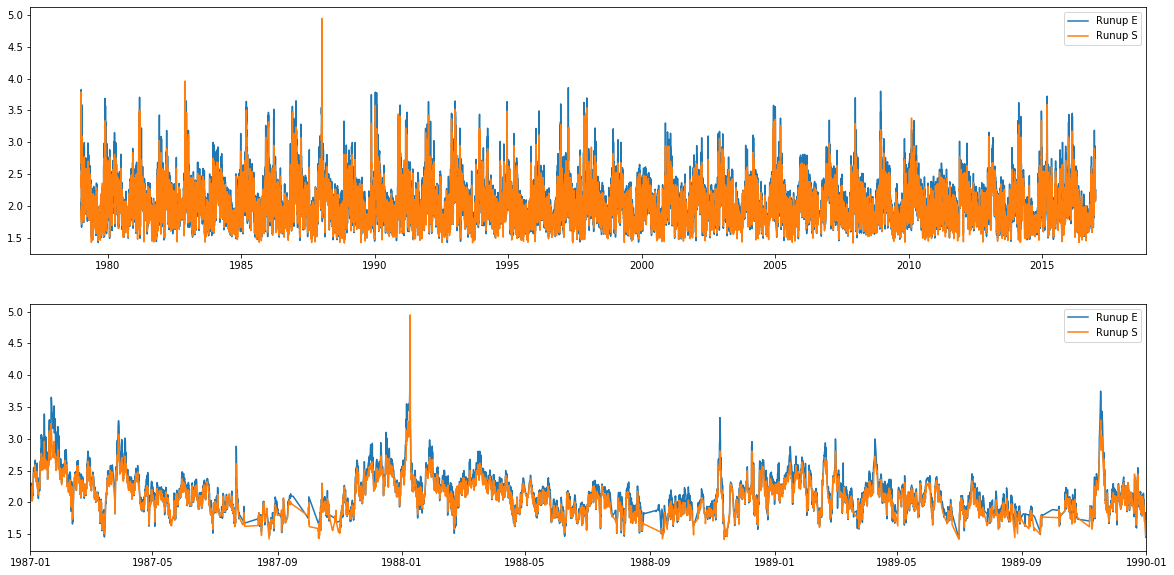

In [11]:
fig, axs = plt.subplots(2,1, figsize=(20,10))

axs[0].plot(out_hist_E.time, out_hist_E.runup, label='Runup E')
axs[0].plot(out_hist_S.time, out_hist_S.runup, label='Runup S')
axs[0].legend()

# zoom
axs[1].plot(out_hist_E.time, out_hist_E.runup, label='Runup E')
axs[1].plot(out_hist_S.time, out_hist_S.runup, label='Runup S')
axs[1].legend()
axs[1].set_xlim(datetime.datetime(1987,1,1),datetime.datetime(1990,1,1))
